In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Helper functions

In [2]:
def compute_plane_eqn_from_points(points, plane_name='Input'):
    """
    Compute the equation of a plane from a set of points using Principal Component Analysis (PCA).

    Parameters:
        points (numpy.ndarray): A 2D array representing the points in 3D space. Each row represents a point, 
                                and each column represents the coordinate (x, y, z).
        plane_name (str, optional): Name of the plane for identification (default is 'Input').

    Returns:
        numpy.ndarray: A 1D array representing the normal vector to the plane.

    Description:
        This function computes the equation of a plane that best fits the given set of points using Principal 
        Component Analysis (PCA). It first calculates the mean of the points and then computes the covariance 
        matrix. Next, it finds the eigenvectors and eigenvalues of the covariance matrix and selects the 
        eigenvector corresponding to the smallest eigenvalue as the normal vector to the plane. Finally, it 
        calculates the coefficients (a, b, c) of the plane equation ax + by + cz = d and returns the normal 
        vector.

    Example:
        >>> points = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        >>> normal_vector = compute_plane_eqn_from_points(points, 'Custom')
        >>> print(normal_vector)
        [0.57735027 0.57735027 0.57735027]
    """
    # Compute the mean of the points
    mean_point = np.mean(points, axis=0)
    
    # Compute the covariance matrix
    cov_matrix = np.cov(points, rowvar=False)
    
    # Find the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Find the index of the smallest eigenvalue
    min_eigenvalue_index = np.argmin(eigenvalues)
    
    # Normal vector to the plane
    normal_vector = eigenvectors[:, min_eigenvalue_index]
    
    # Coefficients (a, b, c) of the plane equation ax + by + cz = d
    a, b, c = normal_vector
    
    # Calculate d using the mean point
    d = -np.dot(normal_vector, mean_point)
    
    # Equation of the plane
    # print(f"Equation of the {plane_name} plane: {a}x + {b}y + {c}z + {d} = 0")
    return normal_vector

In [3]:
def compute_angles(top_layer_centroids_df, base_layer_centroids_df, caption_pairs_df):
    """
    Compute the angles of tilt between connecting vectors and the normal vector to the base plane.

    Parameters:
        top_layer_centroids_df (pandas.DataFrame): DataFrame containing centroids of components in the top layer.
        base_layer_centroids_df (pandas.DataFrame): DataFrame containing centroids of components in the base layer.
        caption_pairs_df (pandas.DataFrame): DataFrame containing pairs of captions linking top and base layers.

    Returns:
        pandas.DataFrame: DataFrame containing angles of tilt for each connecting vector.

    Description:
        This function computes the angles of tilt between connecting vectors and the normal vector to the base plane.
        It first merges the top and base layer centroid DataFrames using the caption_pairs DataFrame. Then, it 
        calculates the connecting vectors connecting the centroids of a cell in the top and base layer. Next, it 
        computes the vector normal to the base plane using the centroids of the base layer. Finally, it computes 
        the angle of tilt between each connecting vector and the normal vector and adds this information to the 
        DataFrame.

    Example:
        >>> angles_df = compute_angles(top_centroids_df, base_centroids_df, caption_pairs_df)
        >>> print(angles_df.head())
    """
    # Merge point coordinates DataFrames using the caption_pairs DataFrame
    top_centroids_captions_merged_df = pd.merge(caption_pairs_df, top_layer_centroids_df[['Caption', 'PosX', 'PosY', 'PosZ']], how = 'inner', left_on = 'TopLayer', right_on = 'Caption')
    top_centroids_captions_merged_df.drop(columns = ['Caption'], inplace = True)
    top_centroids_captions_merged_df = top_centroids_captions_merged_df.rename(columns = {'PosX': 'PosXTop', 'PosY': 'PosYTop', 'PosZ': 'PosZTop'})
    
    centroids_captions_merged_df = pd.merge(top_centroids_captions_merged_df, base_layer_centroids_df[['Caption', 'PosX', 'PosY', 'PosZ']], how = 'inner', left_on = 'BaseLayer', right_on = 'Caption')
    centroids_captions_merged_df.drop(columns = ['Caption'], inplace = True)
    centroids_captions_merged_df = centroids_captions_merged_df.rename(columns = {'PosX': 'PosXBase', 'PosY': 'PosYBase', 'PosZ': 'PosZBase'})

    # Create connecting vectors
    centroids_captions_merged_df['ConnectingVectorX'] = centroids_captions_merged_df['PosXTop'] - centroids_captions_merged_df['PosXBase']
    centroids_captions_merged_df['ConnectingVectorY'] = centroids_captions_merged_df['PosYTop'] - centroids_captions_merged_df['PosYBase']
    centroids_captions_merged_df['ConnectingVectorZ'] = centroids_captions_merged_df['PosZTop'] - centroids_captions_merged_df['PosZBase']

    base_layer_centroid_coords = base_layer_centroids_df[['PosX', 'PosY', 'PosZ']].values
    
    # Get the vector normal to the base plane
    normal_vector = compute_plane_eqn_from_points(base_layer_centroid_coords, 'Base')
    
    # Compute the connecting vectors connecting the centroids of a cell in the top and base layer
    connecting_vectors = centroids_captions_merged_df[['ConnectingVectorX', 'ConnectingVectorY', 'ConnectingVectorZ']].values
    
    # Compute the angle between the connecting vector and the normal vector
    angle_degrees = np.degrees(np.arccos(np.dot(connecting_vectors, normal_vector) / np.linalg.norm(connecting_vectors, axis = 1)))

    centroids_captions_merged_df['AngleOfTilt'] = angle_degrees

    return centroids_captions_merged_df

In [4]:
def compute_and_write_angles(dataset):
    """
    Compute the angles of tilt for a dataset. Driver function for compute_angles().

    Parameters:
        dataset (string): Dataset to compute the angles for.

    Returns:
        No return value.
    """
    # Read point coordinates for the Base and Top layers
    top_layer_centroids_df = pd.read_csv('angle_data/TopLayerCentroids_' + dataset + '.csv')
    base_layer_centroids_df = pd.read_csv('angle_data/BaseLayerCentroids_' + dataset + '.csv')
    
    # Read caption pairs
    caption_pairs_df = pd.read_csv('angle_data/' + dataset + '_caption_pairs.csv')
    
    # Get angles of tilt
    angles_df = compute_angles(top_layer_centroids_df, base_layer_centroids_df, caption_pairs_df)
    
    # Save angle of tilt DataFrame
    angles_df.to_csv('angle_data/' + dataset + '_single_cell_tilts.csv')

# Compute angles for all datasets

In [5]:
# Compute the angles and write them into a CSV file for all tilt datasets
datasets = ['1x', '1o25x', '1o5x', '1o75x', '2x']

for dataset in datasets:
    compute_and_write_angles(dataset)

### Violin plot of distributions for all angles

In [6]:
angles_1x_df = pd.read_csv('angle_data/1x_single_cell_tilts.csv')
angles_1x_df['Dataset'] = '1x'
angles_1o25x_df = pd.read_csv('angle_data/1o25x_single_cell_tilts.csv')
angles_1o25x_df['Dataset'] = '1o25x'
angles_1o5x_df = pd.read_csv('angle_data/1o5x_single_cell_tilts.csv')
angles_1o5x_df['Dataset'] = '1o5x'
angles_1o75x_df = pd.read_csv('angle_data/1o75x_single_cell_tilts.csv')
angles_1o75x_df['Dataset'] = '1o75x'
angles_2x_df = pd.read_csv('angle_data/2x_single_cell_tilts.csv')
angles_2x_df['Dataset'] = '2x'

angles_df = pd.concat([angles_1x_df, angles_1o25x_df, angles_1o5x_df, angles_1o75x_df, angles_2x_df])

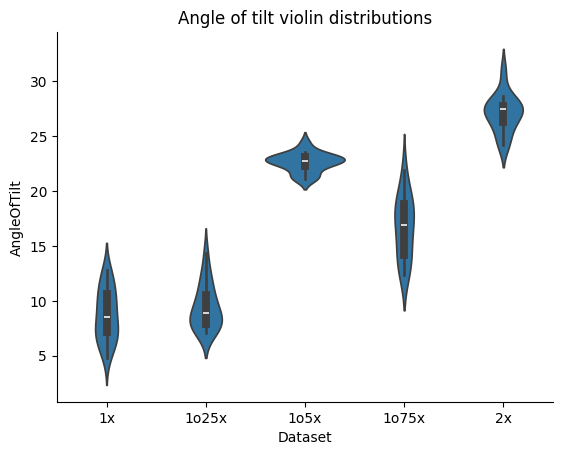

In [7]:
ax = sns.violinplot(data = angles_df, x = 'Dataset', y = 'AngleOfTilt')
ax.set_title('Angle of tilt violin distributions')
sns.despine()
ax.figure.savefig('figures/angle_of_tilt_violin_plot.png', dpi=600)

# Create caption pairs for a dataset

In [19]:
#########################################################################################################
# BE CAREFUL WHILE RUNNING THIS CELL. EXISTING DATA MAY BE OVERWRITTEN WRONGLY IF NOT CAREFUL AND A LOT 
# OF REWORK WILL BE REQUIRED TO FIX THE DATA
#########################################################################################################
# Create pairs of top and base layer centroid captions belonging to the same cell
caption_pairs = {
    'BaseLayer': [18, 13, 19, 16, 11, 3, 15, 7, 8, 1, 17, 12, 10, 4, 6, 9],
    'TopLayer': [14, 9, 16, 6, 8, 10, 12, 15, 11, 18, 22, 19, 21, 13, 17, 20]
}

caption_pairs_df = pd.DataFrame(caption_pairs)
# caption_pairs_df.to_csv('1o75x_caption_pairs.csv', index = False)